​
# <font color=green>SARIMA Model (p, d, q)(P, D, Q, S)</font>:
SARIMA stands for Seasonal Auto Regressive Integrated Moving Average.

## <font color=green>Seasonal ARIMA</font>:
​
The **p, d, q** parameters are capitalized to differ from the non seasonal parameters.
​
* **SAR(P)** is the seasonal autoregression of the series.
    * The formula for the SAR(P) model is: $\hat{y}_{t} = \mu + \theta_{1}Y_{t-s}$ Where P is quantity of autoregression terms to be added, usually no more than 1 term, **s** is how many periods ago to be used as base and $\theta$ is the parameter fitted to the data.
    * Usually when the subject is weather forecasting, 12 months ago have some information to contribute to the current period.
    * Setting P=1 (i.e., SAR(1)) adds a multiple of $Y_{t-s}$ to the forecast for $y_{t}$
    
* **I(D)** the seasonal difference MUST be used when you have an strong and stable pattern.
     * If d = 0 and D = 1: $y_{t} = Y_{t} - Y_{t-s}$ where $y_{t}$ is the differenced series and $Y_{t-s}$ is the original seasonal lag.
     * If d =1 and D = 1: $y_{t} = (Y_{t} - Y_{t-1}) - (Y_{t-s} - Y_{t-s-1}) = Y_{t} - Y_{t-1} -Y_{t-s} + Y_{t-s-1}$
     * D should never be more than 1, and d+D should never be more than 2. Also, if d+D =2, the constant term should be suppressed.
     
* **SMA(Q)** 
     * Setting Q=1 (i.e., SMA(1)) adds a multiple of error $e_{t-s}$ to the forecast for $y_{t}$
​
​
* **S** It's the seasonal period where you are going to calculate the the P, D, Q terms. If there is a 52 week seasonal correlation this is the number to be used on the 'S' parameter
  
  ## <font color=green>Trend</font>:
  
We will use [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) to create a forecast, the following terms are a definition to the trend:
​
 * 'n' when there is no trend to be used (default).
 * ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial)
 * ‘t’ indicates a linear trend with time
 * ‘ct’ is both trend and constant. 
 * Can also be specified as an iterable defining the polynomial as in numpy.poly1d, where [1,1,0,1] would denote a+bt+ct3

In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [31]:
df= pd.read_csv('asia_clean.csv')
df.head()

,Unnamed: 0,dt,AverageTemperature,AverageTemperatureUncertainty,Country,Year
0,0,1990-01-01,1.558,0.460,Afghanistan,1990
1,1,1990-02-01,3.669,0.244,Afghanistan,1990
2,2,1990-03-01,8.402,0.311,Afghanistan,1990
3,3,1990-04-01,14.457,0.231,Afghanistan,1990
4,4,1990-05-01,22.442,0.316,Afghanistan,1990


In [32]:
china = df.loc[df['Country'] == 'China', ['dt','AverageTemperature']]
china.columns = ['Date','Temp']
china['Date'] = pd.to_datetime(china['Date'])
china.reset_index(drop=True, inplace=True)
china.set_index('Date', inplace=True)

china.head()

,Temp
Date,
1990-01-01,-7.151
1990-02-01,-3.761
1990-03-01,2.889
1990-04-01,7.676
1990-05-01,13.765


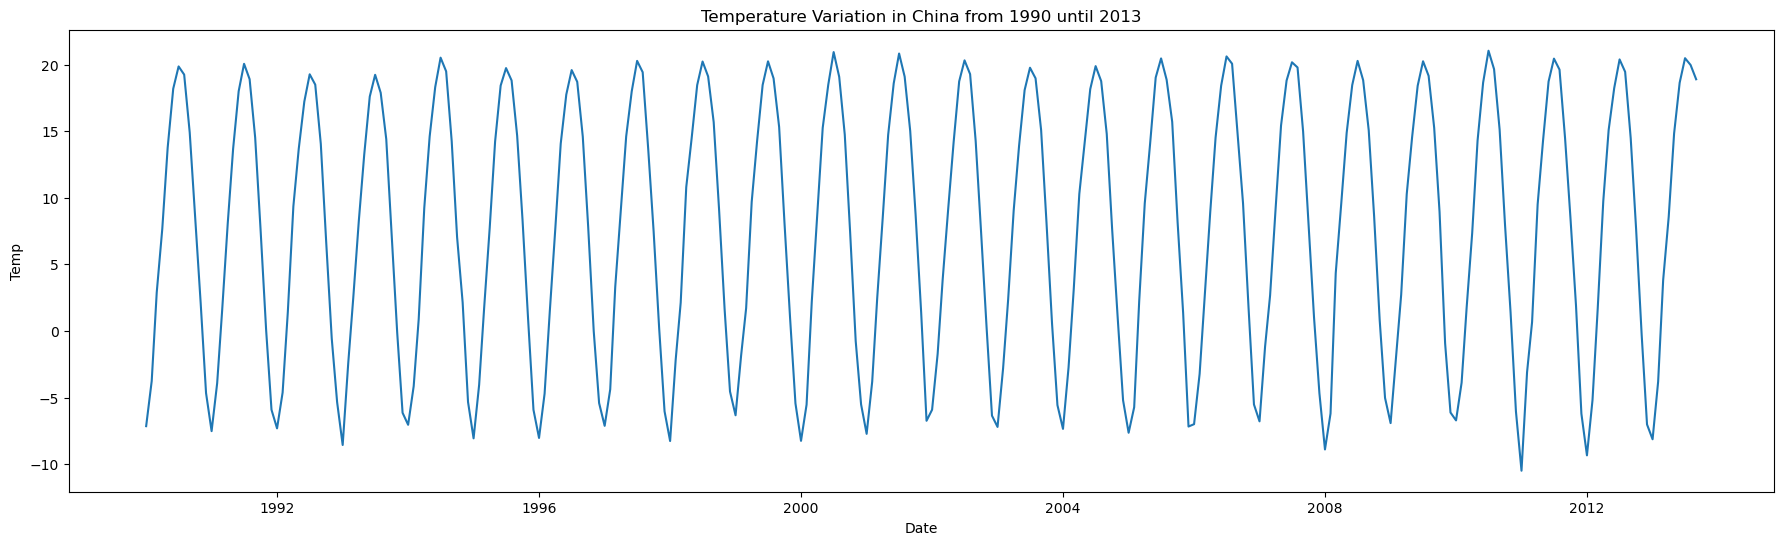

In [33]:
plt.figure(figsize=(22,6))
sns.lineplot(x=china.index, y=china['Temp'])
plt.title('Temperature Variation in China from 1990 until 2013')
plt.show()

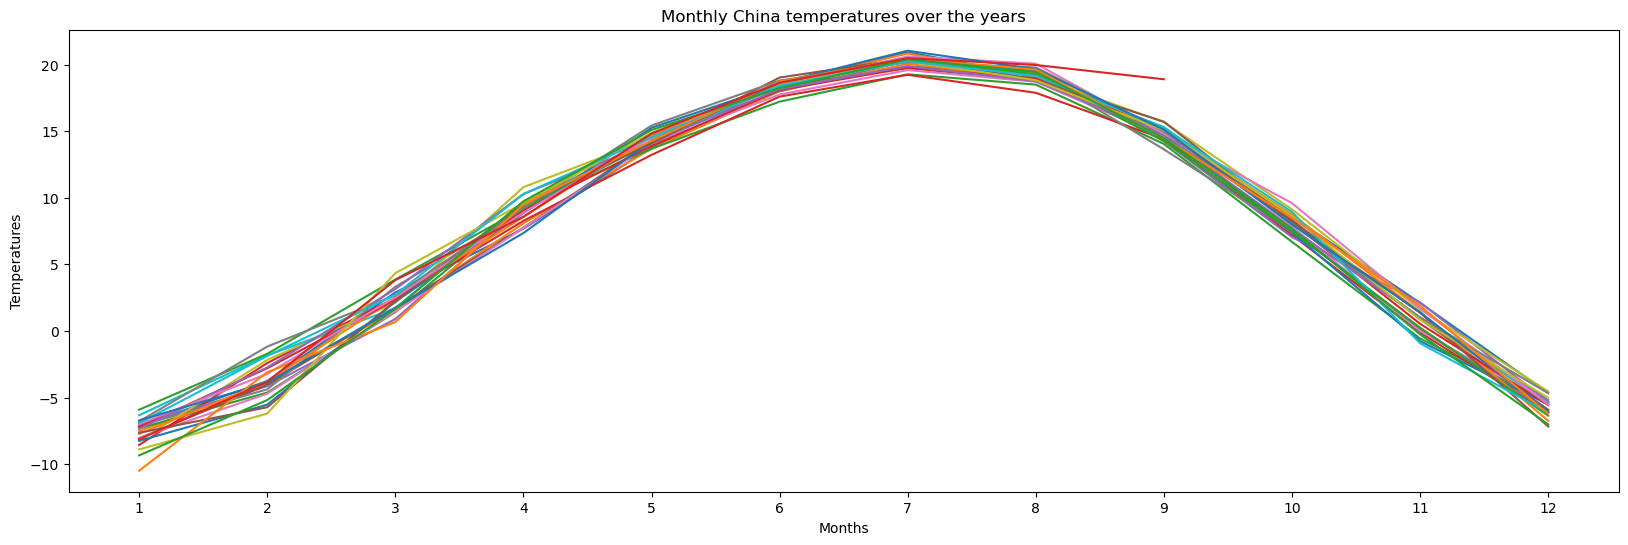

In [57]:
#plot the monthly temperatures 
china['month'] = china.index.month
china['year'] = china.index.year
pivot = pd.pivot_table(china, values='Temp', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Monthly China temperatures over the years')
plt.xlabel('Months')
plt.ylabel('Temperatures')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

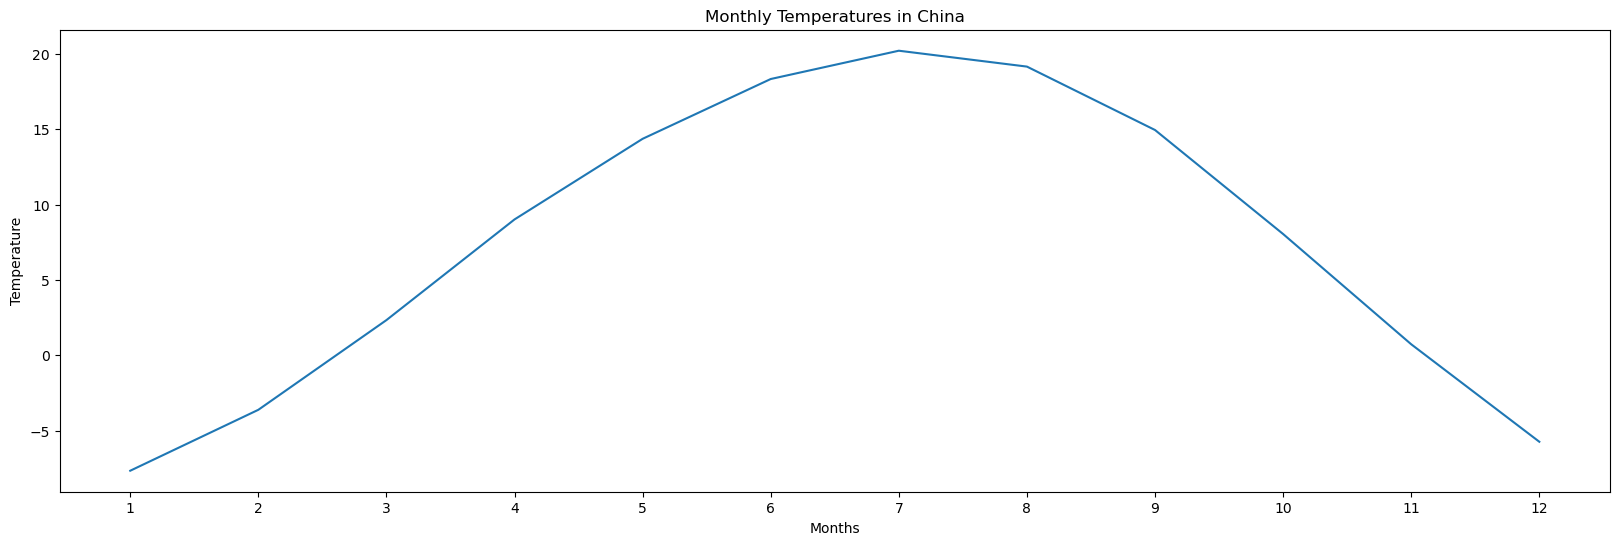

In [35]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Temperatures in China')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1,13)])
plt.show()

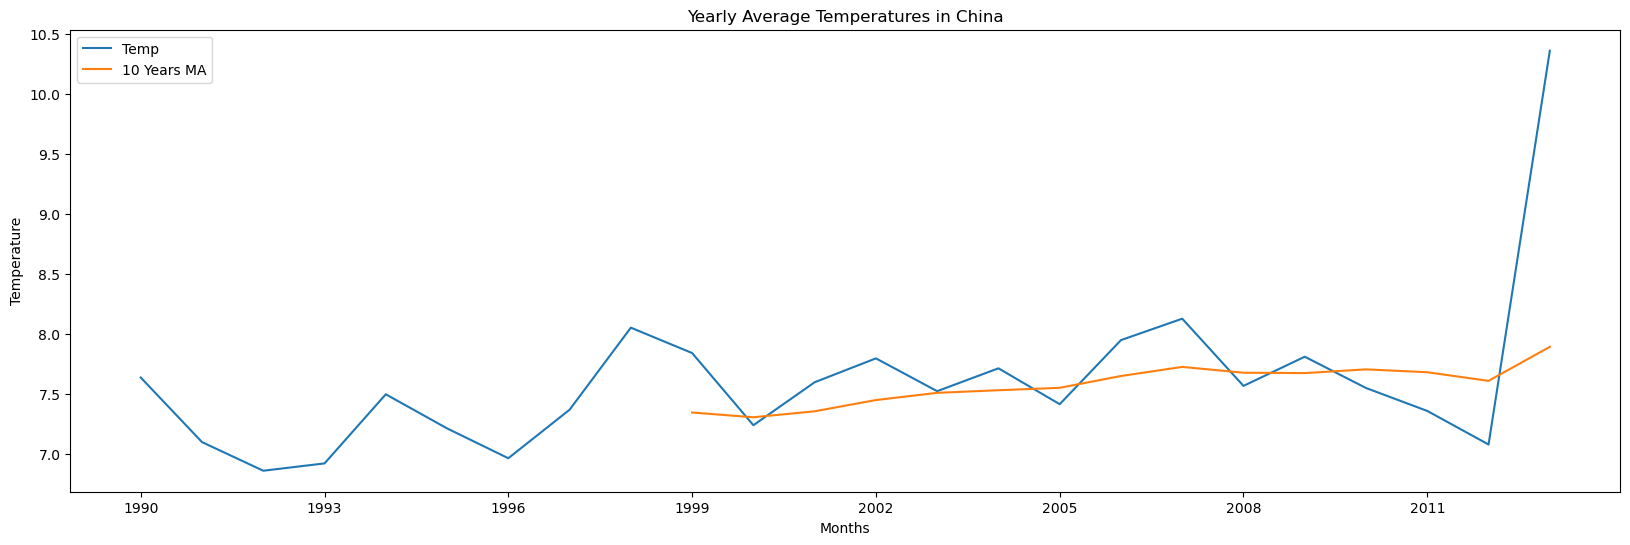

In [85]:
year_avg = pd.pivot_table(china, values='Temp', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['Temp'].rolling(10).mean()
year_avg[['Temp','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly Average Temperatures in China')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(1990,2013,3)])
plt.show()

In [37]:
train = china[:-60].copy()
val = china[-60:-12].copy()
test = china[-12:].copy()

79% of the data was used for training, 17% for validation, and 4% for testing the model

In [38]:
# Excluding the first line, as it has NaN values
baseline = val['Temp'].shift()
baseline.dropna(inplace=True)
baseline.head()

Date
2008-11-01    8.635
2008-12-01    0.840
2009-01-01   -5.029
2009-02-01   -6.921
2009-03-01   -1.879
Name: Temp, dtype: float64

In [98]:
def measure_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true,y_pred))

# Using the function with the baseline values
rmse_base = measure_rmse(val.iloc[1:,0],baseline)
print(f'The RMSE of the baseline that we will try to diminish is {round(rmse_base,4)} degree Celsius')

The RMSE of the baseline that we will try to diminish is 5.3176 degree Celsius


In [40]:
def check_stationarity(y, lags_plots=48, figsize=(22,8)):
    "Use Series as parameter"
    
    # Creating plots of the DF
    y = pd.Series(y)
    fig = plt.figure()

    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=2)

    y.plot(ax=ax1, figsize=figsize)
    ax1.set_title('China Temperature Variation')
    plot_acf(y, lags=lags_plots, zero=False, ax=ax2);
    plot_pacf(y, lags=lags_plots, zero=False, ax=ax3);
    sns.distplot(y, bins=int(sqrt(len(y))), ax=ax4)
    ax4.set_title('Distribution Chart')

    plt.tight_layout()
    
    print('Results of Dickey-Fuller Test:')
    adfinput = adfuller(y)
    adftest = pd.Series(adfinput[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adftest = round(adftest,4)
    
    for key, value in adfinput[4].items():
        adftest["Critical Value (%s)"%key] = value.round(4)
        
    print(adftest)
    
    if adftest[0].round(2) < adftest[5].round(2):
        print('\nThe Test Statistics is lower than the Critical Value of 5%.\nThe series seems to be stationary')
    else:
        print("\nThe Test Statistics is higher than the Critical Value of 5%.\nThe series isn't stationary")

Results of Dickey-Fuller Test:
Test Statistic                  -2.6640
p-value                          0.0805
Lags Used                       14.0000
Number of Observations Used    210.0000
Critical Value (1%)             -3.4619
Critical Value (5%)             -2.8754
Critical Value (10%)            -2.5742
dtype: float64

The Test Statistics is higher than the Critical Value of 5%.
The series isn't stationary


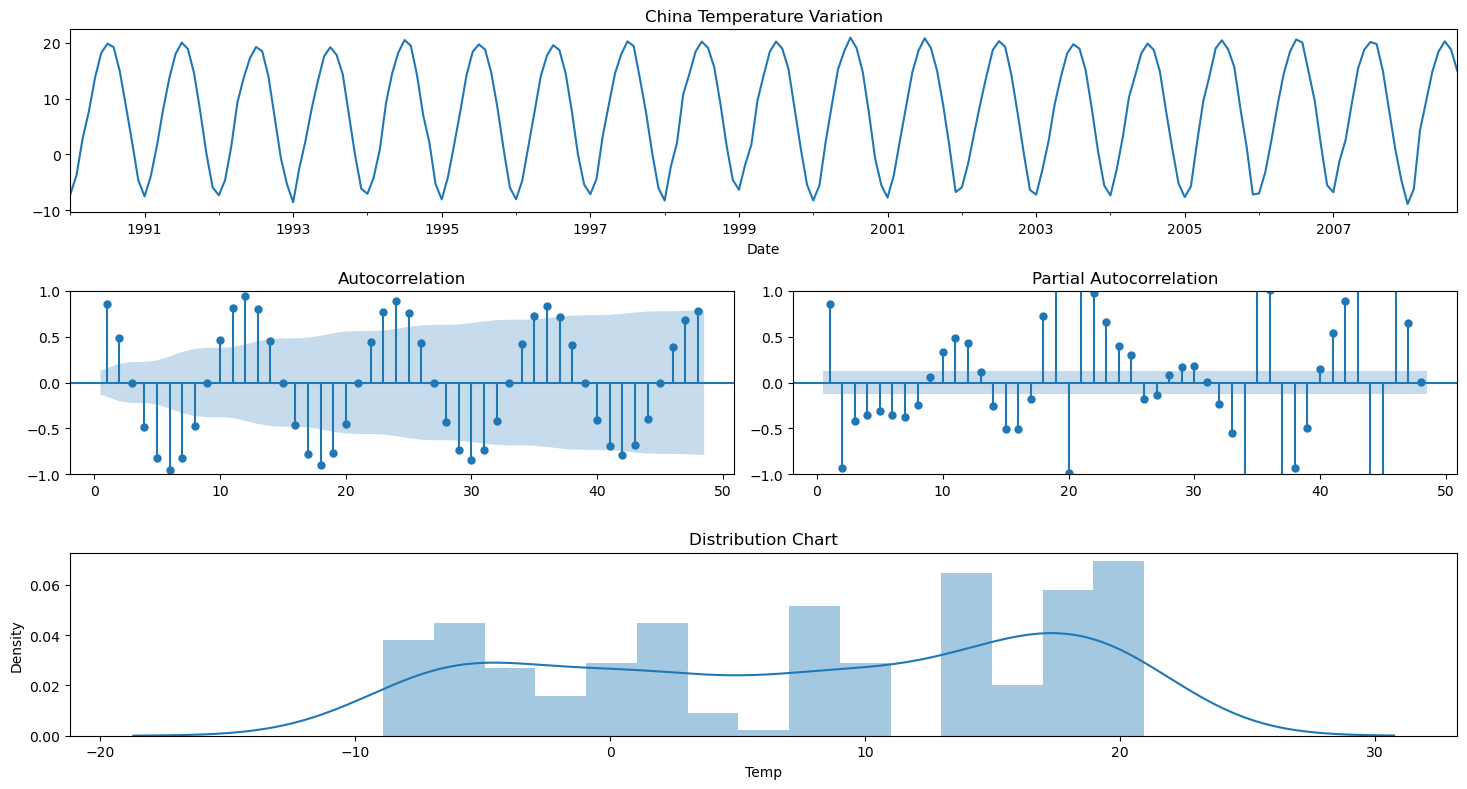

In [41]:
# The first approach is to check the series without any transformation
check_stationarity(train['Temp'])

Results of Dickey-Fuller Test:
Test Statistic                  -5.9103
p-value                          0.0000
Lags Used                       11.0000
Number of Observations Used    201.0000
Critical Value (1%)             -3.4633
Critical Value (5%)             -2.8760
Critical Value (10%)            -2.5745
dtype: float64

The Test Statistics is lower than the Critical Value of 5%.
The series seems to be stationary


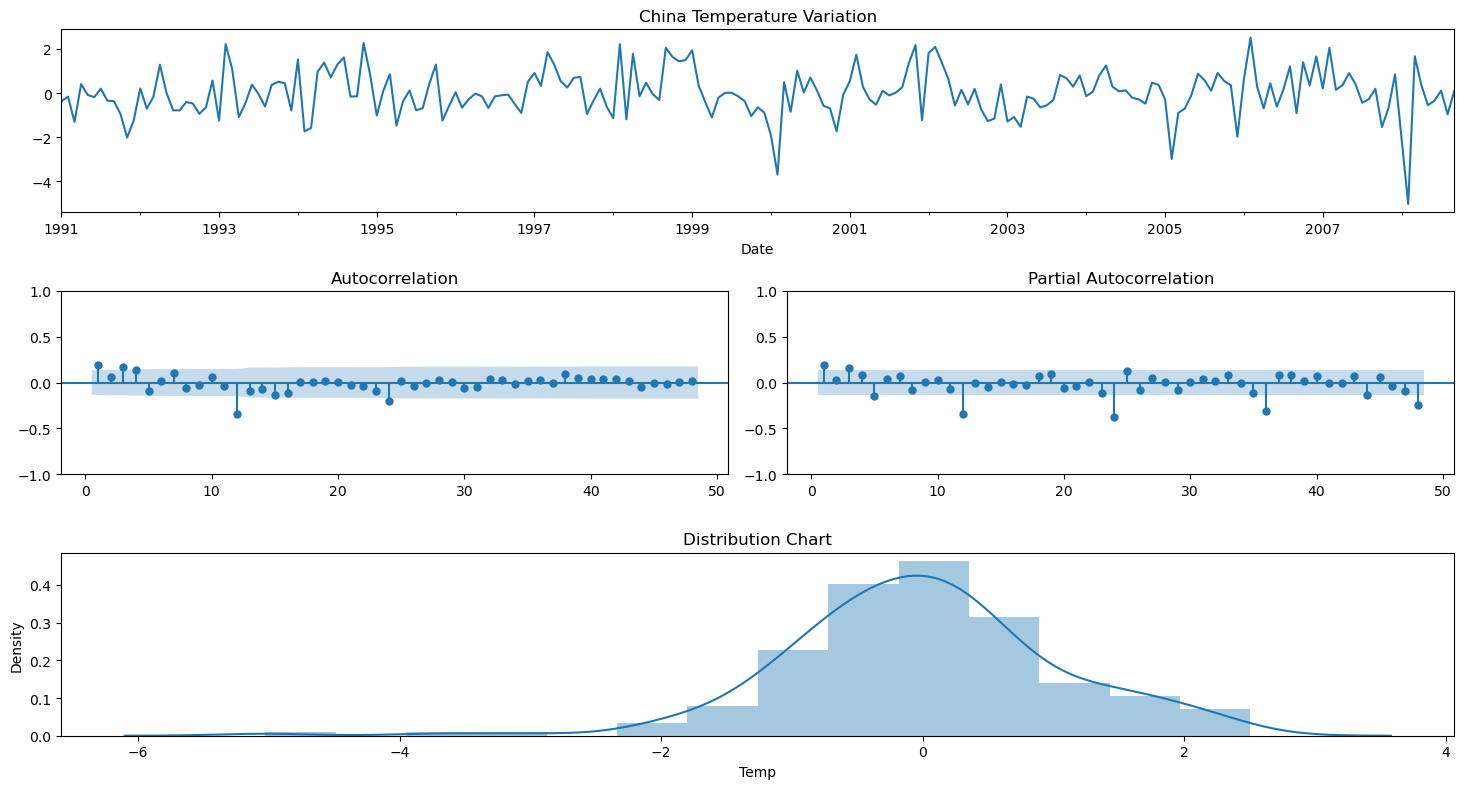

In [42]:
check_stationarity(train['Temp'].diff(12).dropna())

As the plots above showed, the first ACF lags have a gradual decay, while the PACF drops under the confidence interval after the fifth lag, this is an AR signature with a parameter of 5, so this is an AR(5) model.

As we used a first seasonal difference, the ACF and PACF showed a significative drop in the 11th lag, it means an SMA signature with a parameter of 1 lag, resuming this is an SAR(1) with a first difference.

Initially i'm going to work with the following (p,d,q) orders: (5, 0, 0), and with the following seasonal (P, D, Q, S) orders (0,1,1,12) and as the series has a clear uptrend i'm going to use it in the model ('c').

To start forecasting the validation set, I'm going to create a function to use one-step-forecast in the whole validation set and measure the error:

In [43]:
def walk_forward(training_set, validation_set, params):
    '''
    Params: it's a tuple where you put together the following SARIMA parameters: ((pdq), (PDQS), trend)
    '''
    history = [x for x in training_set.values]
    prediction = list()
    
    # Using the SARIMA parameters and fitting the data
    pdq, PDQS, trend = params

    #Forecasting one period ahead in the validation set
    for week in range(len(validation_set)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq, seasonal_order=PDQS, trend=trend)
        result = model.fit(disp=False)
        yhat = result.predict(start=len(history), end=len(history))
        prediction.append(yhat[0])
        history.append(validation_set[week])
        
    return prediction

In [68]:
# Let's test it in the validation set
val['Pred'] = walk_forward(train['Temp'], val['Temp'], ((5,0,0),(0,1,1,12),'c'))


In [99]:
# Measuring the error of the prediction
rmse_pred = measure_rmse(val['Temp'], val['Pred'])

print(f"The RMSE of the SARIMA(5,0,0),(0,1,1,12),'c' model was {round(rmse_pred,4)} degree Celsius")
print(f"It's a decrease of {round((rmse_pred/rmse_base-1)*100,2)}% in the RMSE")

The RMSE of the SARIMA(5,0,0),(0,1,1,12),'c' model was 0.9476 degree Celsius
It's a decrease of -82.18% in the RMSE


In [70]:
# Creating the error column
val['Error'] = val['Temp'] - val['Pred']

In [78]:
def plot_error(data, figsize=(20,8)):
    '''
    There must have 3 columns following this order: Temperature, Prediction, Error
    '''
    plt.figure(figsize=figsize)
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))
    ax3 = plt.subplot2grid((2,2), (1,0))
    ax4 = plt.subplot2grid((2,2), (1,1))
    
    #Plotting the Current and Predicted values
    ax1.plot(data.iloc[:,0:2])
    ax1.legend(['Real','Pred'])
    ax1.set_title('Current and Predicted Values')
    
    # Residual vs Predicted values
    ax2.scatter(data.iloc[:,1], data.iloc[:,2])
    ax2.set_xlabel('Predicted Values')
    ax2.set_ylabel('Errors')
    ax2.set_title('Errors versus Predicted Values')
    
    ## QQ Plot of the residual
    sm.graphics.qqplot(data.iloc[:,2], line='r', ax=ax3)
    
    # Autocorrelation plot of the residual
    plot_acf(data.iloc[:,2], lags=(len(data.iloc[:,2])-1),zero=False, ax=ax4)
    plt.tight_layout()
    plt.show()

In [80]:
val.head()

,Temp,Pred,Error
Date,,,
2008-10-01,8.635,8.258888,0.376112
2008-11-01,0.840,1.168541,-0.328541
2008-12-01,-5.029,-5.334959,0.305959
2009-01-01,-6.921,-6.991191,0.070191
2009-02-01,-1.879,-3.199576,1.320576


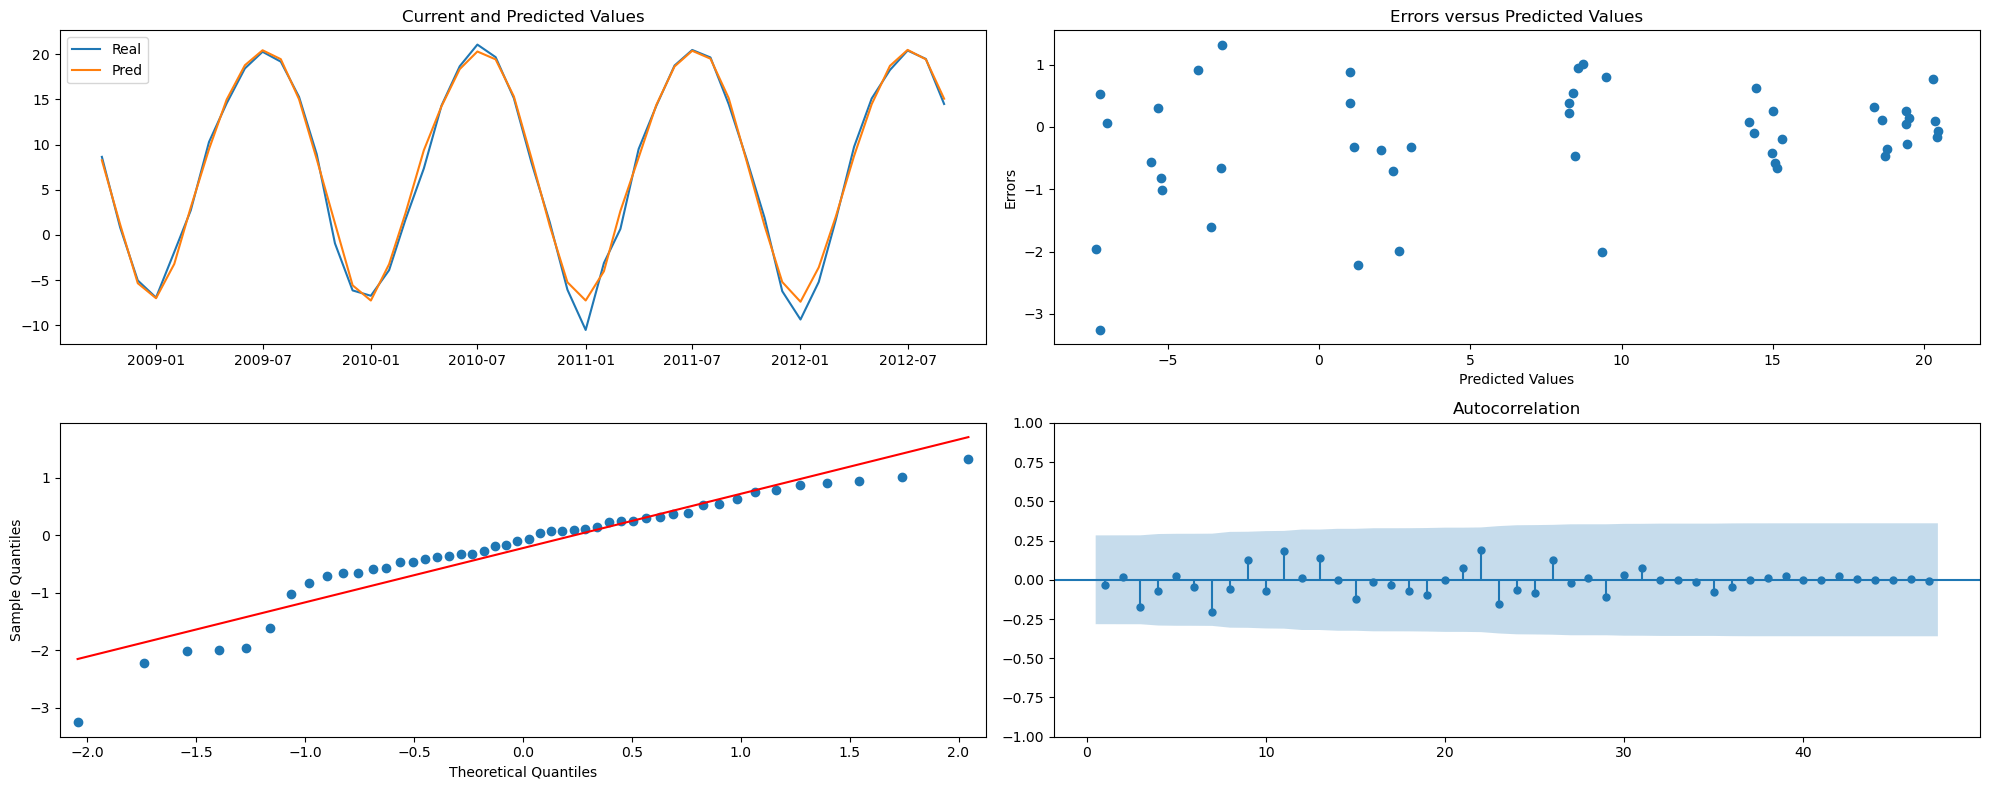

In [79]:
plot_error(val)

Analyzing the plots above we can see that the predictions fit very well on the current values.

The **Error vs Predicted values** has a linear distribution (the errors are mostly between -2 and +1, which is fairly acceptable).

The QQ Plot shows a normal pattern with some little outliers and,

The autocorrelation plot shows a zero spikes over the confidence interval, hence we believe that there is no need for more changes.

Finally it's time to extrapolate the prediction in the **test set** for the last 12 months

In [74]:
#Creating the new concatenating the training and validation set:
future = pd.concat([train['Temp'], val['Temp']])
future.head()

Date
1990-01-01    -7.151
1990-02-01    -3.761
1990-03-01     2.889
1990-04-01     7.676
1990-05-01    13.765
Name: Temp, dtype: float64

In [75]:
# Using the same parameters of the fitted model
model = sm.tsa.statespace.SARIMAX(future, order=(3,0,0), seasonal_order=(0,1,1,12), trend='c')
result = model.fit(disp=False)

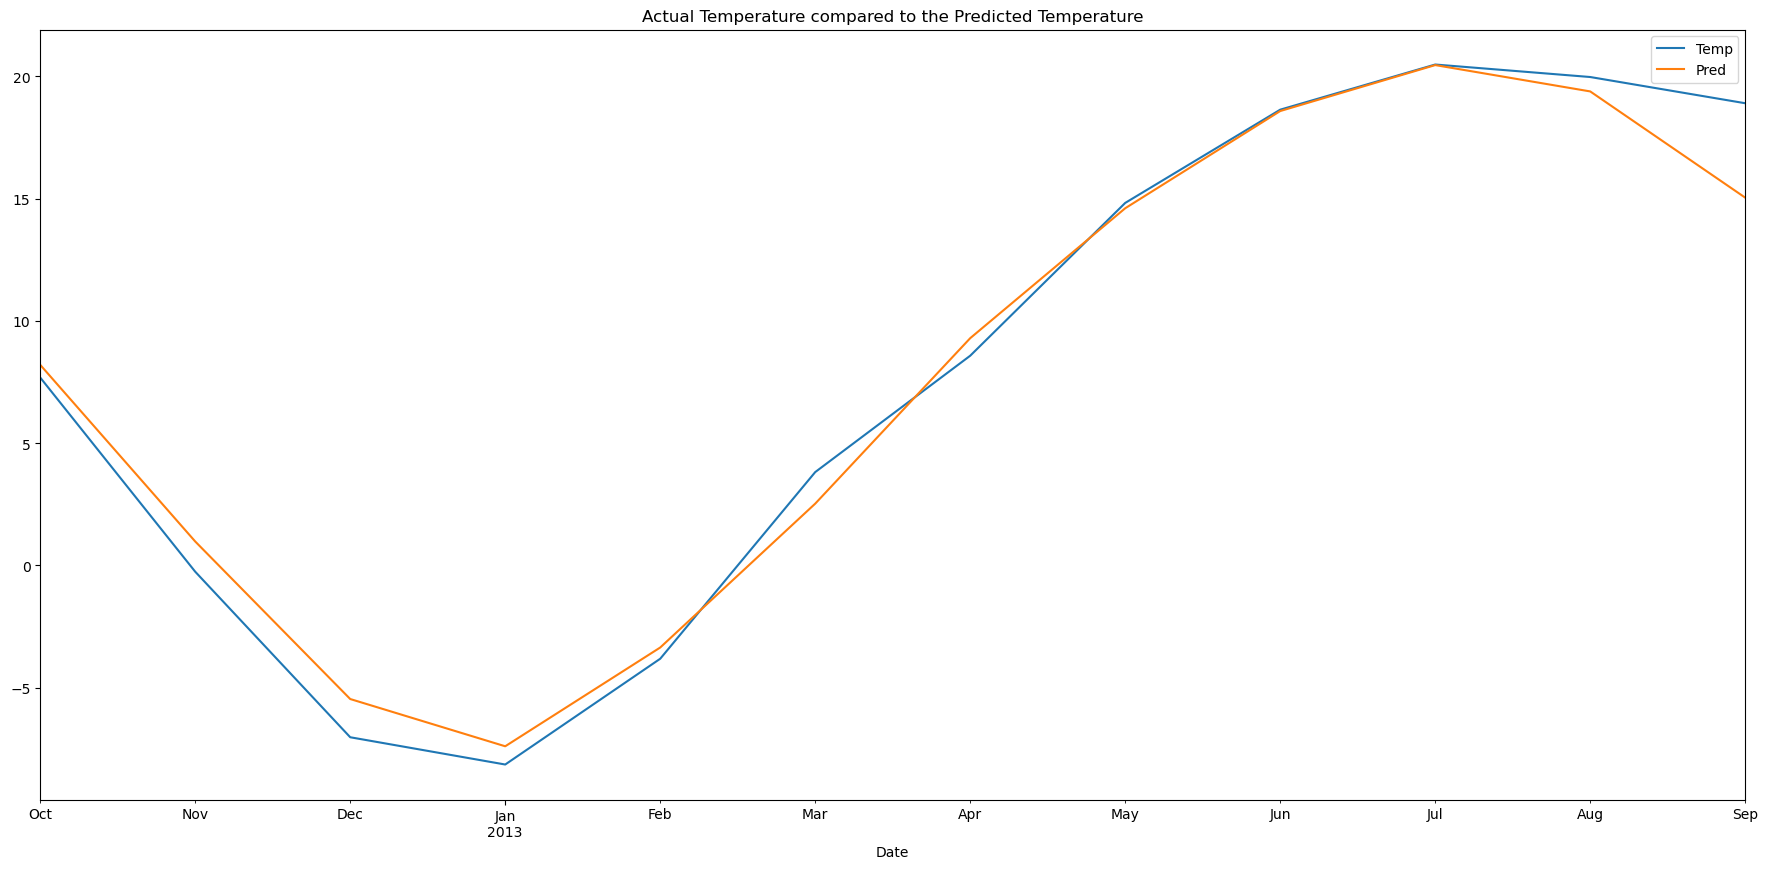

In [76]:
test['Pred'] = result.predict(start=(len(future)), end=(len(future)+365))
test[['Temp', 'Pred']].plot(figsize=(22,10))
plt.title('Actual Temperature compared to the Predicted Temperature')
plt.show()


It seems that the SARIMA parameters were well fitted, the predicted values are following the majority of the real values and also the seasonal pattern.

Lastly would be to evaluate the model with the RMSE in the test set (baseline against the extrapolation):

In [100]:
test_baseline = test['Temp'].shift()

test_baseline[0] = test['Temp'][0]

rmse_test_base = measure_rmse(test['Temp'],test_baseline)
rmse_test_extrap = measure_rmse(test['Temp'], test['Pred'])

print(f'The baseline RMSE for the test baseline was {round(rmse_test_base,2)} degree Celsius')
print(f'The baseline RMSE for the test extrapolation was {round(rmse_test_extrap,2)} degree Celsius')
print(f'That is an improvement of {-round((rmse_test_extrap/rmse_test_base-1)*100,2)}%')

The baseline RMSE for the test baseline was 4.73 degree Celsius
The baseline RMSE for the test extrapolation was 1.37 degree Celsius
That is an improvement of 71.04%


In [92]:
!pip install pmdarima


     -------------------------------------- 569.7/569.7 kB 8.9 MB/s eta 0:00:00
     ------------------------------------- 988.1/988.1 kB 10.4 MB/s eta 0:00:00


In [93]:
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [96]:
# Find the best parameters for SARIMAX model using auto_arima function
model = pm.auto_arima(train.to_numpy().ravel(), seasonal=True, m=12, suppress_warnings=True)
print(model.order)
print(model.seasonal_order)


(0, 0, 0)
(2, 1, 2, 12)


In [102]:
# Choose "temperature" column as endog variable
endog_train = train['Temp']

# Fit SARIMAX model
model = SARIMAX(endog_train, order=(1,1,1), seasonal_order=(0,1,1,12), trend='c')
model_fit = model.fit()

# Validate SARIMAX model
val['forecast'] = model_fit.predict(start=val.index[0], end=val.index[-1], dynamic=True)
rmse = sqrt(mean_squared_error(val['Temp'], val['forecast']))
print('Validation RMSE: %.3f' % rmse)


Validation RMSE: 0.992


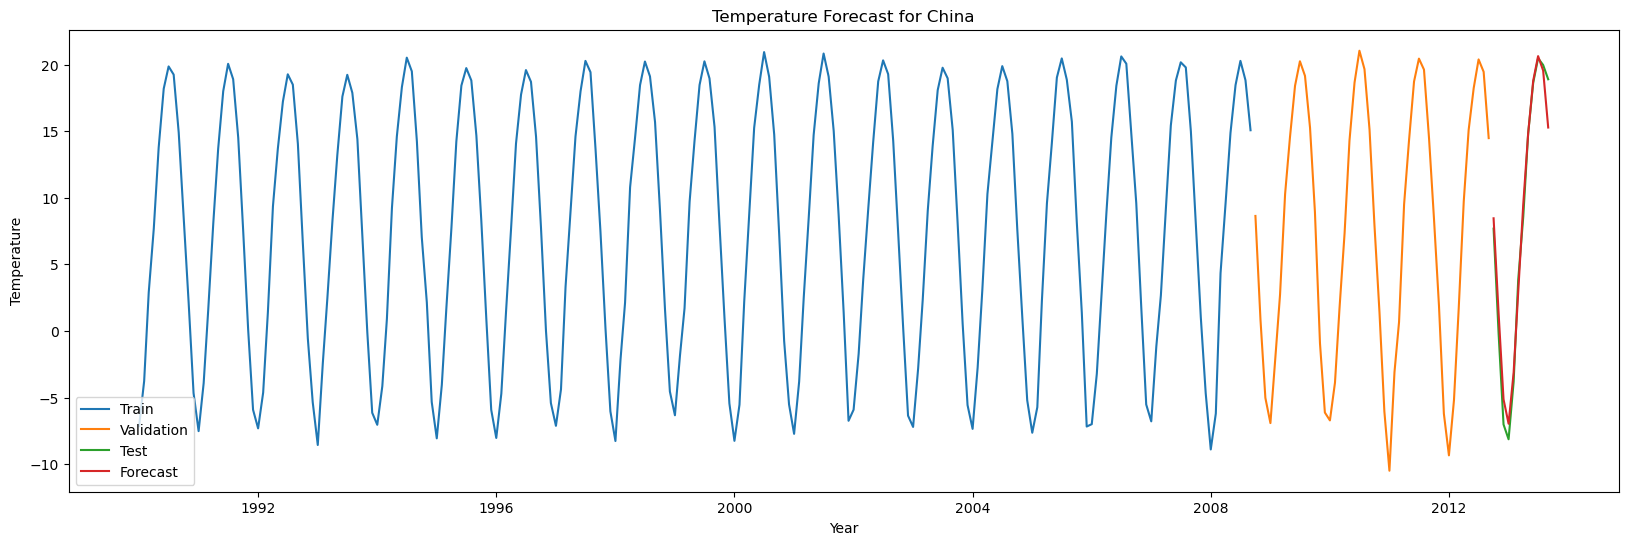

In [107]:
# Forecast for test set
test['forecast'] = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=True)

# Plot the results
plt.figure(figsize=(20,6))
plt.plot(train.index, train['Temp'], label='Train')
plt.plot(val.index, val['Temp'], label='Validation')
plt.plot(test.index, test['Temp'], label='Test')
plt.plot(test.index, test['forecast'], label='Forecast')
plt.title('Temperature Forecast for China')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.legend()
plt.show()


This is another way to view the test,val,train and prediction data. As show, the forecast plot is very well fitted to that of the test plot. 